In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import OneHotEncoder as OHE

from metric_calculator import METRIC_CALCULATOR

2024-05-01 15:48:59.927535: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-01 15:48:59.927770: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-01 15:48:59.930134: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-01 15:48:59.955871: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 15:49:00.355767: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

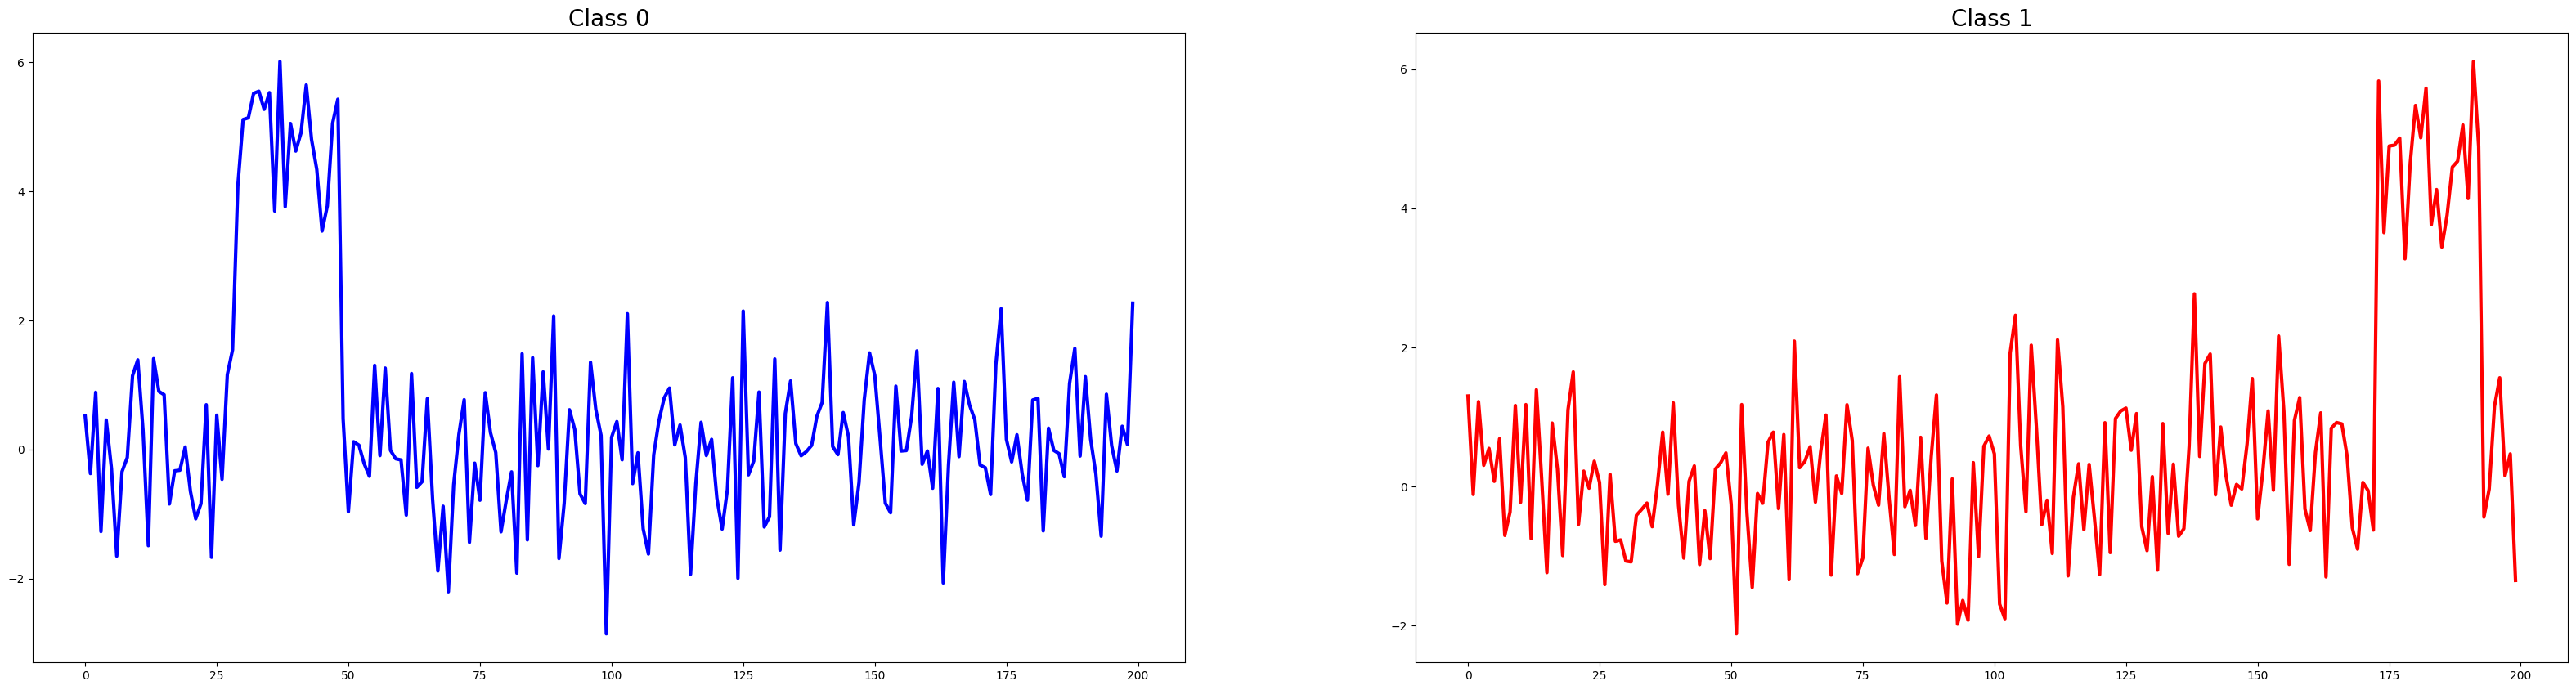

In [2]:
## Create synthetic data

data = np.random.normal(size=(100, 200))
labels = np.zeros(shape=(100,))

for i in range(50):

    start_indice = np.random.randint(low=0,high=100-20, size=1)[0]
    stop_indice = start_indice + 20

    data[i,start_indice:stop_indice] += 5

for i in range(50,100):

    start_indice = np.random.randint(low=100,high=200-20, size=1)[0]
    stop_indice = start_indice + 20

    data[i,start_indice:stop_indice] += 5
    labels[i] = 1

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(40,10))

ax[0].plot(data[np.random.randint(low=0, high=50)], lw=3, color='blue')
ax[0].set_title('Class 0', fontsize=20)

ax[1].plot(data[np.random.randint(low=50, high=100)], lw=3, color='red')
ax[1].set_title('Class 1', fontsize=20)

plt.show()

In [3]:
## Create the gen model

input_layer_encoder = tf.keras.layers.Input((200,))

downsample = tf.keras.layers.Dense(units=50)(input_layer_encoder)
latent_space = tf.keras.layers.Dense(units=10)(downsample)

encoder = tf.keras.models.Model(inputs=input_layer_encoder, outputs=latent_space)

input_layer_decoder = tf.keras.layers.Input((10,))

upsample = tf.keras.layers.Dense(units=50)(input_layer_decoder)
output_layer = tf.keras.layers.Dense(units=200)(upsample)

decoder = tf.keras.models.Model(inputs=input_layer_decoder, outputs=output_layer)

input_layer_auto_encoder = tf.keras.layers.Input((200,))
encoder_output = encoder(input_layer_auto_encoder)
output_layer_auto_encoder = decoder(encoder_output)

auto_encoder = tf.keras.models.Model(inputs=input_layer_auto_encoder, outputs=output_layer_auto_encoder)

auto_encoder.compile(loss='mse', optimizer='Adam')

auto_encoder.fit(data, data, batch_size=32, epochs=5)

Epoch 1/5


2024-05-01 15:49:01.685787: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2224  
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 3.7940
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5864 
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4800 
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 3.3727


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Text(0.5, 1.0, 'Generated Sample Class 1')

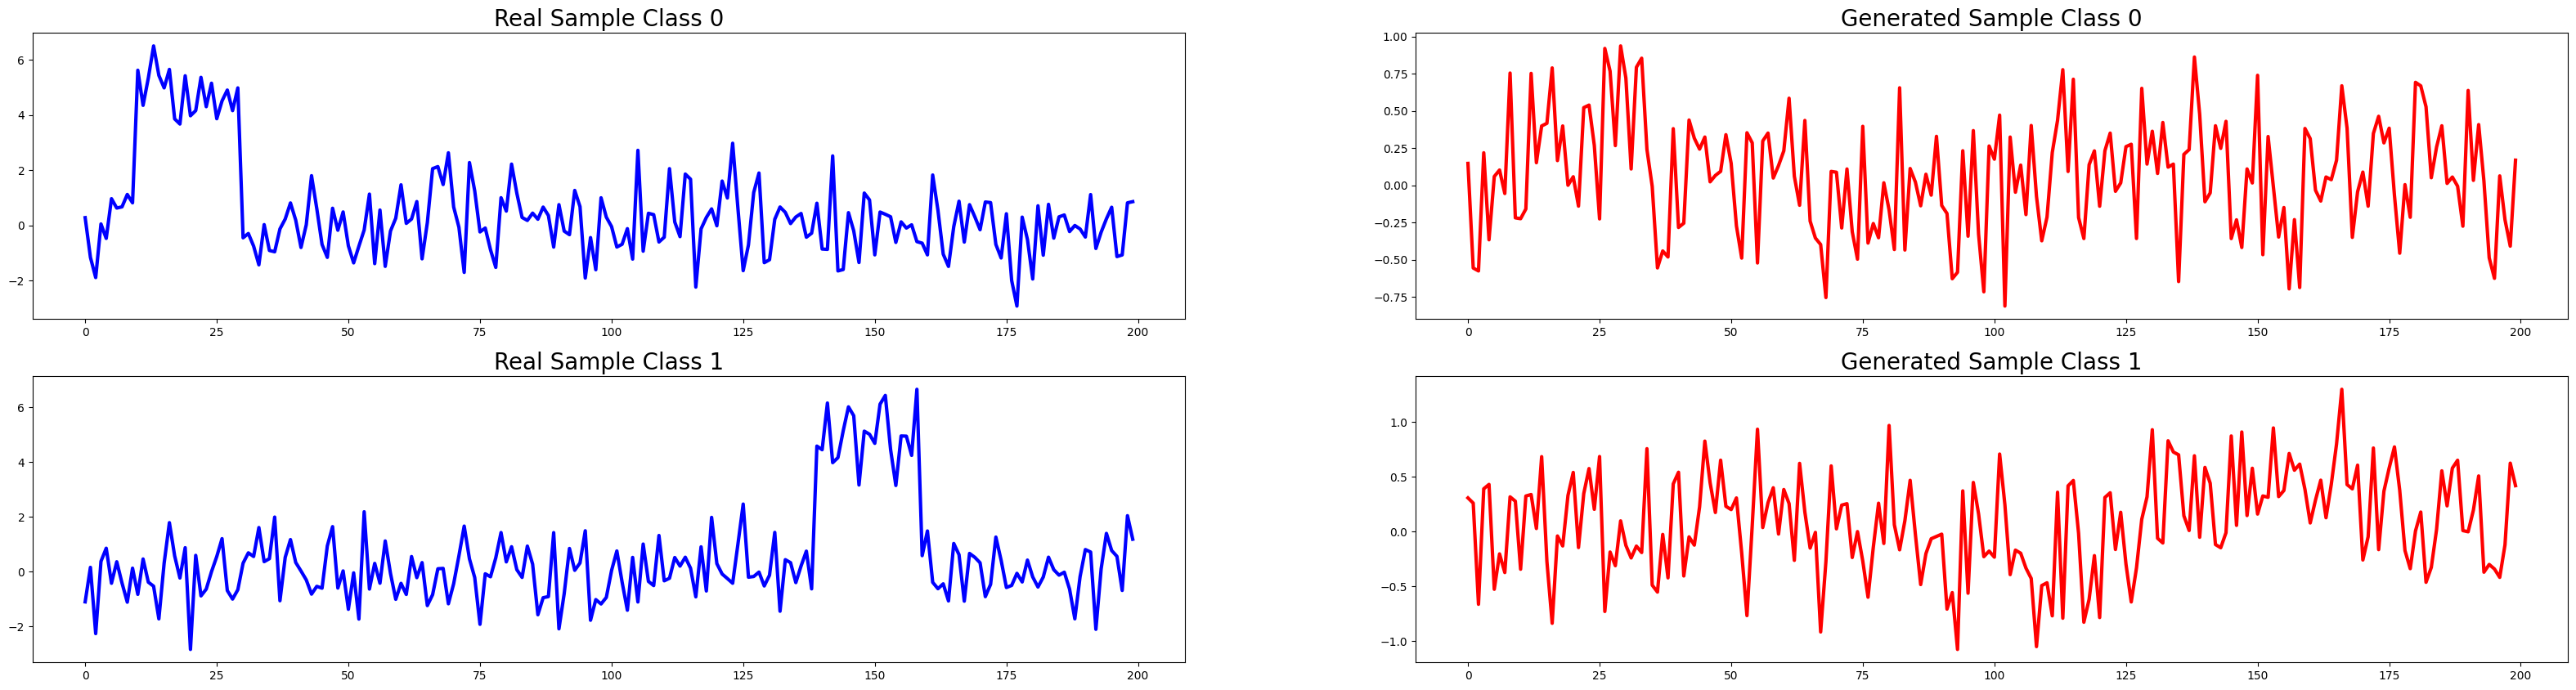

In [4]:
x = data

latent_space = encoder.predict(x)

z00 = latent_space[labels == 0][0]
z01 = latent_space[labels == 0][1]

z10 = latent_space[labels == 1][0]
z11 = latent_space[labels == 1][10]

z0 = (z00 + z01) / 2
z1 = (z10 + z11) / 2

y0 = np.squeeze(decoder.predict(np.expand_dims(z0, axis=0)), axis=0)
y1 = np.squeeze(decoder.predict(np.expand_dims(z1, axis=0)), axis=0)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(40,10))

ax[0,0].plot(x[0], lw=3, color='blue')
ax[0,0].set_title('Real Sample Class 0', fontsize=20)

ax[0,1].plot(y0, lw=3, color='red')
ax[0,1].set_title('Generated Sample Class 0', fontsize=20)

ax[1,0].plot(x[50], lw=3, color='blue')
ax[1,0].set_title('Real Sample Class 1', fontsize=20)

ax[1,1].plot(y1, lw=3, color='red')
ax[1,1].set_title('Generated Sample Class 1', fontsize=20)

In [5]:
## Create Classifier

input_layer = tf.keras.layers.Input((200,))
hidden_layer = tf.keras.layers.Dense(units=50)(input_layer)
output_layer = tf.keras.layers.Dense(units=2, activation="softmax")(hidden_layer)

classifier = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
classifier.compile(
    loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"]
)

ohe = OHE(sparse_output=False)
labels_ohe = ohe.fit_transform(np.expand_dims(labels, axis=1))

classifier.fit(data, labels_ohe, batch_size=32, epochs=1000)

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6013 - loss: 1.9297  
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.7808 - loss: 0.7623
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.9693 - loss: 0.1026
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.9939 - loss: 0.0218
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 1.0000 - loss: 0.0040
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0026 
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0011 
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 4.5497e-04 
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.0475e-04
Epoch 10/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.3252e-04 
Epoch 11/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.9279e-04 
Epoch 12/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3

In [6]:
generated_samples = auto_encoder.predict(data)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/stepWARNING:tensorflow:5 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7323b00de710> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [7]:
args = {
    "fid": {
        "classifier": classifier,
        "batch_size": 32,
    },
    "density": {
        "classifier": classifier,
        "batch_size": 32,
    },
    "apd": {
        "classifier": classifier,
        "Sapd": 100,
        "batch_size": 32,
    },
    "acpd": {
        "classifier": classifier,
        "batch_size": 32,
    },
    "coverage": {
        "classifier": classifier,
        "batch_size": 32,
    },
    "aog": {
        "classifier": classifier,
        "batch_size": 32,
    },
    "mms": {
        "classifier": classifier,
        "batch_size": 32,
    },
    "wpd": {
        "Swpd": 200,
    }
}

metric_calculator = METRIC_CALCULATOR(args=args, output_dir="./")

print(
    metric_calculator.get_metrics_csv(
        xgenerated=generated_samples, ygenerated=labels, xreal=data, yreal=labels
    )
)

fid
density
apd
acpd
coverage
aog
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
mms
(100, 2)
wpd
fid
density
apd
acpd
coverage
aog
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step
mms
wpd
          On         fid  density        apd       acpd  coverage   aog  \
0       real   82.570676    0.976  23.693796  20.472737       1.0  1.00   
1  generated  266.930958    1.454   6.176139   5.759716       0.3  0.82   

         mms        wpd  
0  12.425711  23.557503  
1  13.555039   7.116894  
